In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression

In [3]:
analysis_df = pd.read_csv('data/analysis_dataset.csv')
analysis_df.head()


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,log1p_n_interactions,log1p_interactions_per_month,log1p_n_unique_users,log_minutes_w,log1p_n_interactions_w,log1p_interactions_per_month_w,log1p_n_unique_users_w,rating_gap,bayes_gap,wilson_gap
0,arriba baked winter squash mexican style,137739,55.0,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,1.386294,0.012371,1.386294,4.007333,1.386294,0.012371,1.386294,0.000,0.257361,0.561506
1,a bit different breakfast pizza,31490,30.0,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,1.386294,0.010657,1.609438,3.401197,1.386294,0.010657,1.609438,0.333,0.334208,0.561506
2,all in the kitchen chili,112140,130.0,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,...,0.693147,0.004029,0.693147,4.867534,0.693147,0.004029,0.693147,1.000,0.395063,0.793457
3,alouette potatoes,59389,45.0,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...",...,1.098612,0.007377,1.098612,3.806662,1.098612,0.007377,1.098612,0.500,0.362142,0.657628
4,amish tomato ketchup for canning,44061,190.0,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,...,0.693147,0.003621,0.693147,5.247024,0.693147,0.003625,0.693147,0.000,0.304154,0.793457


In [4]:
EFFORT_COLS = [
    "log_minutes", "log_minutes_w",
    "n_steps", "n_ingredients", 
    "log_n_ingredients", "avg_words_per_step",
    "effort_score", "effort_category"
]

POPULARITY_COLS = [
    "bayes_mean", "wilson_lb", "rating_gap", "bayes_gap", "wilson_gap",
    "n_interactions", "log1p_n_interactions", "log1p_n_interactions_w",
    "interactions_per_month", "log1p_interactions_per_month", "log1p_interactions_per_month_w",
    "n_unique_users", "log1p_n_unique_users", "log1p_n_unique_users_w"
]

CONTROL_COLS = ["age_months", "submitted", "name", "id"]
analysis_vars = analysis_df[EFFORT_COLS + POPULARITY_COLS + CONTROL_COLS].copy()

In [5]:
# Vérifier le volume de données utilisables
analysis_vars[EFFORT_COLS + POPULARITY_COLS].isna().sum()

log_minutes                          0
log_minutes_w                        0
n_steps                              0
n_ingredients                        0
log_n_ingredients                    0
avg_words_per_step                   0
effort_score                         0
effort_category                      0
bayes_mean                        4751
wilson_lb                            0
rating_gap                        4751
bayes_gap                         4751
wilson_gap                           0
n_interactions                       0
log1p_n_interactions                 0
log1p_n_interactions_w               0
interactions_per_month               0
log1p_interactions_per_month         0
log1p_interactions_per_month_w       0
n_unique_users                       0
log1p_n_unique_users                 0
log1p_n_unique_users_w               0
dtype: int64

On observe 4751 NaN dans 'bayes_mean', 'rating_gap' et 'bayes_gap' parce que certaines recettes n'ont aucune note numérique.
# TODO:
# - garder uniquement les recettes avec au moins une note numérique ?
# - attribuer la moyenne globale aux recettes sans note numérique ?

In [6]:
# Inspecter les distributions principales des variables
analysis_vars.describe().T
analysis_vars['effort_category'].value_counts()

effort_category
Très Difficile    173243
Difficile          26743
Modéré             13659
Facile              6012
Très Facile         2156
Name: count, dtype: int64

In [7]:
# Sanity check : s'assurer que les valeurs 'log' et 'winsor' sont cohérentes
analysis_vars[['n_interactions', 'log1p_n_interactions', 'log1p_n_interactions_w']].describe()

,n_interactions,log1p_n_interactions,log1p_n_interactions_w
count,221813.000000,221813.000000,221813.000000
mean,4.597670,1.262220,1.270701
std,16.103787,0.745135,0.698661
min,0.000000,0.000000,0.693147
25%,1.000000,0.693147,0.693147
50%,2.000000,1.098612,1.098612
75%,4.000000,1.609438,1.609438
max,1488.000000,7.305860,3.806662


In [8]:
# Création d'une dictionnaire pour centraliser les colonnes utilisées pour la suite de l'analyse
SELECTED_COLUMNS = {
    "effort":  EFFORT_COLS,
    "popularity": POPULARITY_COLS,
    "control": CONTROL_COLS
}

In [9]:
# Préparer les listes de variables + helper pour les p-values
from itertools import product
from scipy.stats import spearmanr, pearsonr

EFFORT_SPEARMAN = ["log_minutes", "n_steps", "n_ingredients", "effort_score"]
POPULARITY_SPEARMAN = ["bayes_mean", "wilson_lb", "interactions_per_month"]

# Pour Pearson on reste sur la même base mais on prendra les versions « stabilisées »
PEARSON_MAP_EFFORT = {
    "log_minutes": "log_minutes",          # déjà log-transformée
    "n_steps": "n_steps",                  # distribution acceptable
    "n_ingredients": "log_n_ingredients",   # log pour normaliser
    "effort_score": "effort_score"         # déjà normalisée
}
PEARSON_MAP_POP = {
    "bayes_mean": "bayes_mean",
    "wilson_lb": "wilson_lb",
    "interactions_per_month": "log1p_interactions_per_month_w"  # winsor + log1p
}

### Corrélations de Spearman

Spearman = robustesse aux distributions asymétriques --> on légitime l'usage des valeurs brutes

In [10]:
spearman_rows = []
for effort, popularity in product(EFFORT_SPEARMAN, POPULARITY_SPEARMAN):
    subset = analysis_vars[[effort, popularity]].dropna()
    rho, pval = spearmanr(subset[effort], subset[popularity])
    spearman_rows.append(
        {"effort": effort, "popularité": popularity, "rho": rho, "p_value": pval, "n": len(subset)}
    )

spearman_df = (
    pd.DataFrame(spearman_rows)
      .pivot(index="effort", columns="popularité", values="rho")
      .round(3)
)
spearman_df

popularité,bayes_mean,interactions_per_month,wilson_lb
effort,,,
effort_score,-0.026,-0.036,-0.043
log_minutes,-0.034,-0.037,-0.038
n_ingredients,-0.018,-0.022,-0.030
n_steps,-0.001,-0.027,-0.041


In [11]:
# Affichage des p-values de Spearman
spearman_pvalues = (
    pd.DataFrame(spearman_rows)
      .pivot(index="effort", columns="popularité", values="p_value")
      .applymap(lambda x: f"{x:.3g}")
)
spearman_pvalues

/var/folders/zt/2nggs7pd3d5c9ymyqz8z2mm00000gn/T/ipykernel_28216/336238803.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: f"{x:.3g}")


popularité,bayes_mean,interactions_per_month,wilson_lb
effort,,,
effort_score,1.64e-33,3.73e-65,7.74e-92
log_minutes,3.91e-56,1.81e-66,3.04e-70
n_ingredients,6.65e-17,3.77e-26,3.6e-45
n_steps,0.608,2.04e-37,4.61e-82


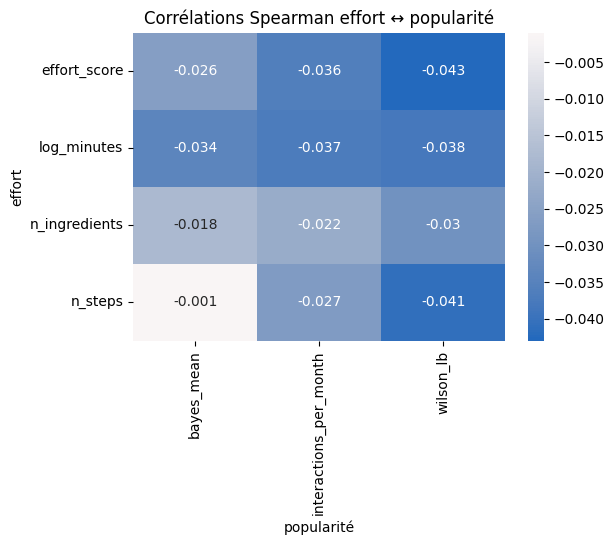

In [12]:
# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(spearman_df, annot=True, cmap="vlag", center=0)
plt.title("Corrélations Spearman effort ↔ popularité")
plt.show()

### Corrélations de Pearson

Pearson = on justifie l'usage de log_n_ingredients et log1p_interactions_per_month_w pour se rapprocher des hypothèses normales/linéaires.

In [13]:
pearson_rows = []
for effort_label, popularity_label in product(EFFORT_SPEARMAN, POPULARITY_SPEARMAN):
    effort_col = PEARSON_MAP_EFFORT[effort_label]
    popularity_col = PEARSON_MAP_POP[popularity_label]
    subset = analysis_vars[[effort_col, popularity_col]].dropna()
    r, pval = pearsonr(subset[effort_col], subset[popularity_col])
    pearson_rows.append(
        {
            "effort": effort_label,
            "popularité": popularity_label,
            "r": r,
            "p_value": pval,
            "n": len(subset),
            "x_utilisé": effort_col,
            "y_utilisé": popularity_col,
        }
    )

pearson_df = (
    pd.DataFrame(pearson_rows)
      .pivot(index="effort", columns="popularité", values="r")
      .round(3)
)
pearson_df

popularité,bayes_mean,interactions_per_month,wilson_lb
effort,,,
effort_score,-0.026,-0.019,-0.043
log_minutes,-0.036,-0.010,-0.037
n_ingredients,-0.011,-0.024,-0.032
n_steps,0.008,-0.021,-0.044


In [14]:
# Affichage des p-values de Pearson
pearson_pvalues = (
    pd.DataFrame(pearson_rows)
      .pivot(index="effort", columns="popularité", values="p_value")
      .applymap(lambda x: f"{x:.3g}")
)
pearson_pvalues

/var/folders/zt/2nggs7pd3d5c9ymyqz8z2mm00000gn/T/ipykernel_28216/4196485958.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: f"{x:.3g}")


popularité,bayes_mean,interactions_per_month,wilson_lb
effort,,,
effort_score,4.68e-34,2.69e-18,2.92e-93
log_minutes,1.54e-64,1.68e-06,2.38e-68
n_ingredients,1.94e-07,8.23e-30,1.59e-52
n_steps,0.00018,2.8e-22,7.59e-96


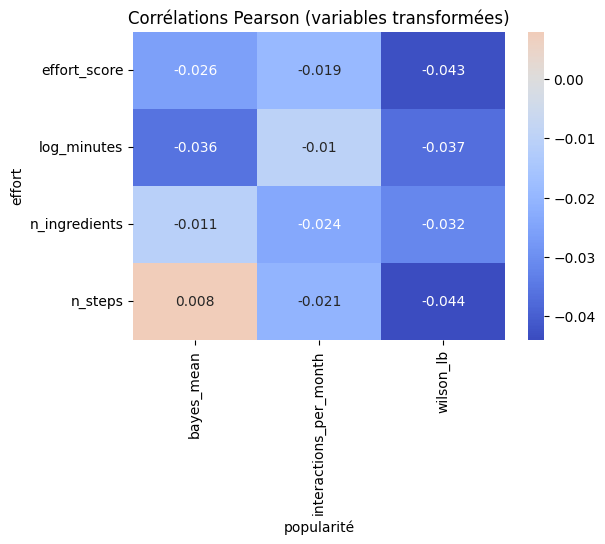

In [15]:
# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pearson_df, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélations Pearson (variables transformées)")
plt.show()

### Remarques

- Corrélations très faibles mais cohérentes :
    - Toutes les corrélations sont comprises entre -0.1 et +0.1, ce qui indique des relations très faibles entre effort culinaire et popularité
    - Les deux méthodes (Spearman et Pearson) donnent des résultats cohérents en termes de direction des corrélations (positives ou négatives), ce qui renforce la robustesse des conclusions.

- Patterns intéressants :
    - Les métriques de satisfaction (bayes_mean, wilson_lb) montrent des corrélations quasi-nulles avec les mesures d'effort, suggérant que l'effort culinaire n'influence pas significativement la satisfaction des utilisateurs. Les gens notent bien les recettes indépendamment de leur complexité.
    - La métrique d'engagement utilisée (interactions_per_month) montre des corrélations négatives faibles, suggérant que les recettes plus simples ont tendance à générer plus d'interactions, mais l'effet est très faible.
        - Les recettes simples pourraient sembler plus accessibles et permettraient que plus d'utilisateurs les testent. À l'inverse, les recettes complexes pourraient décourager certains utilisateurs, réduisant ainsi les interactions.
        - Biais de sélection : les débutants, en clin à des recettes simples, pourraient commenter plus que les autres utilisateurs.

### Visualisations effort <-> popularité

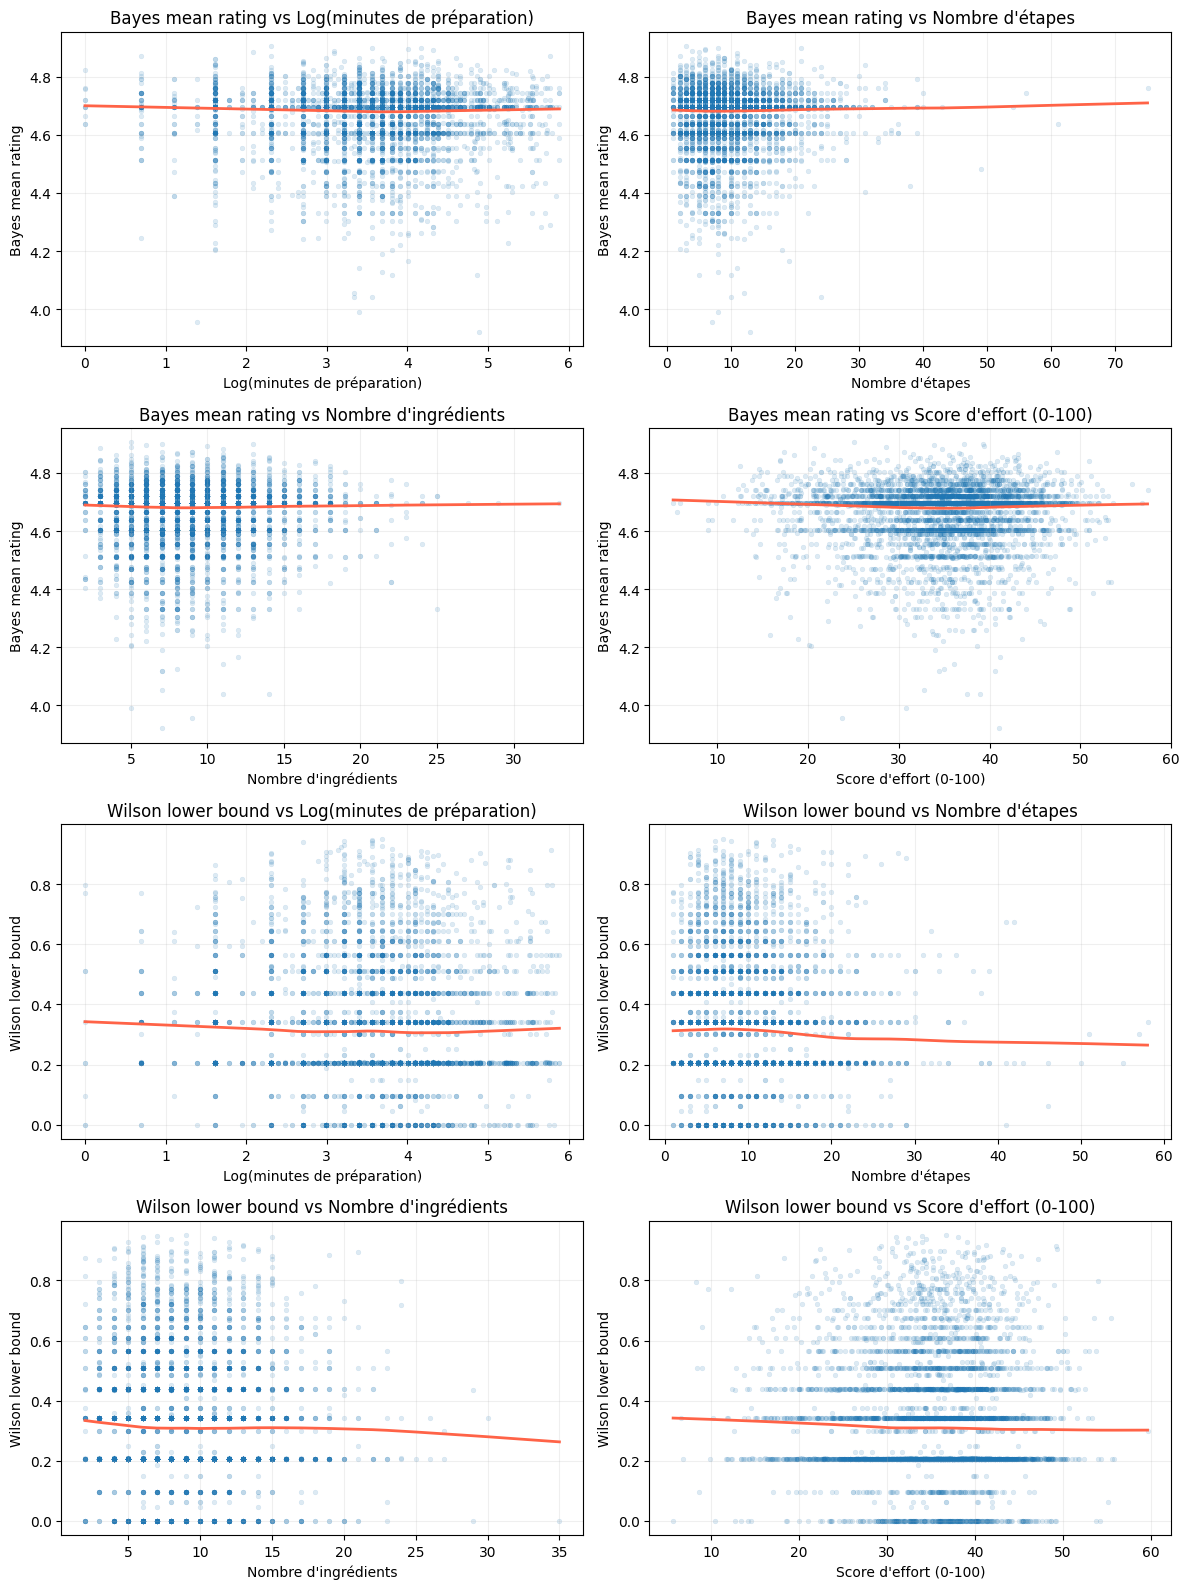

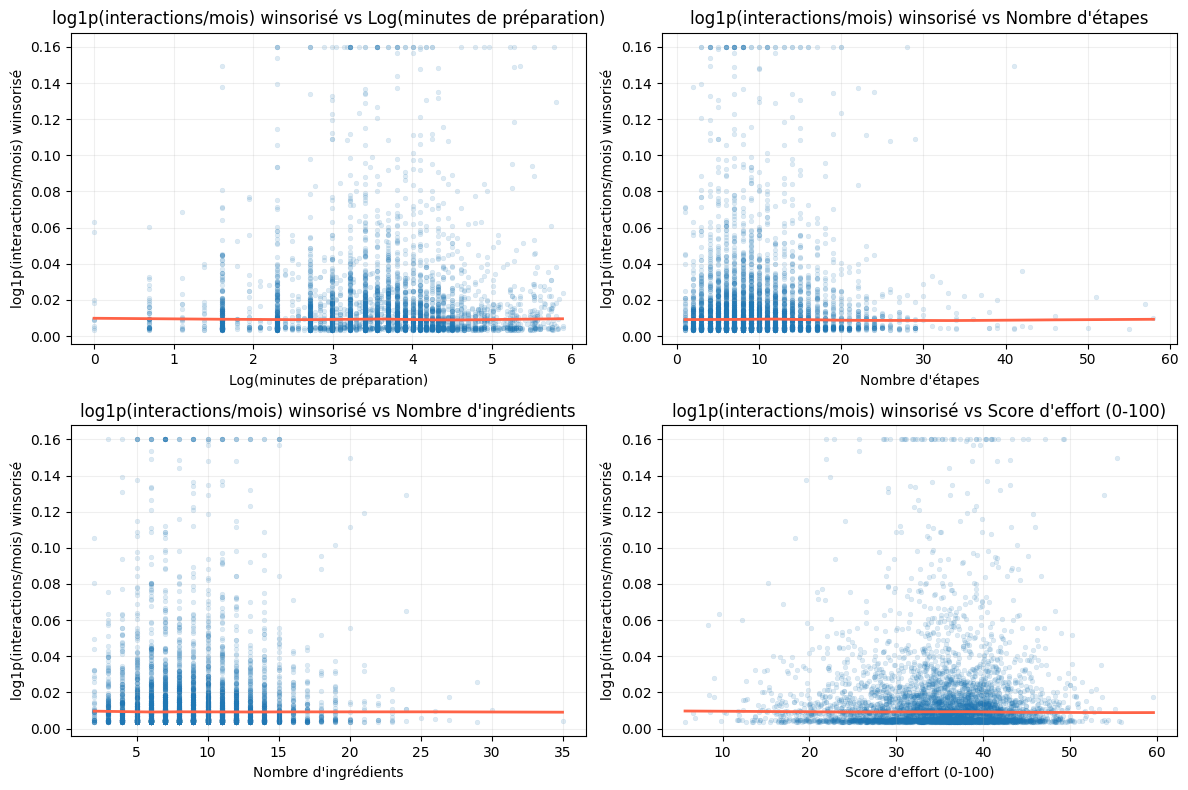

In [27]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import math

# Couples effort / popularité à tracer
SCATTER_PAIRS = [
    ("log_minutes", "bayes_mean"),
    ("n_steps", "bayes_mean"),
    ("n_ingredients", "bayes_mean"),
    ("effort_score", "bayes_mean"),
    ("log_minutes", "wilson_lb"),
    ("n_steps", "wilson_lb"),
    ("n_ingredients", "wilson_lb"),
    ("effort_score", "wilson_lb"),
    # Engagement - on utilise la version log1p winsorisée pour lisser l'échelle
    ("log_minutes", "log1p_interactions_per_month_w"),
    ("n_steps", "log1p_interactions_per_month_w"),
    ("n_ingredients", "log1p_interactions_per_month_w"),
    ("effort_score", "log1p_interactions_per_month_w"),
]

def scatter_with_lowess(df, x, y, ax=None, x_label=None, y_label=None, title=None, sample_size=5000):
    data = df[[x, y]].dropna()
    if sample_size and len(data) > sample_size:
        data = data.sample(sample_size, random_state=42)

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        created_fig = True

    sns.scatterplot(data=data, x=x, y=y, alpha=0.15, s=12, edgecolor=None, ax=ax)
    sns.regplot(data=data, x=x, y=y, scatter=False, lowess=True,
                color="tomato", line_kws={"linewidth": 2}, ax=ax)

    ax.set_xlabel(x_label or x)
    ax.set_ylabel(y_label or y)
    ax.set_title(title or f"{y} vs {x}")
    ax.grid(alpha=0.2)

    if created_fig:
        plt.tight_layout()
    return ax


LABELS = {
    "log_minutes": "Log(minutes de préparation)",
    "n_steps": "Nombre d'étapes",
    "n_ingredients": "Nombre d'ingrédients",
    "effort_score": "Score d'effort (0-100)",
    "bayes_mean": "Bayes mean rating",
    "wilson_lb": "Wilson lower bound",
    "log1p_interactions_per_month_w": "log1p(interactions/mois) winsorisé",
}

def plot_pairs_grid(df, pairs, ncols=2, figsize=(12, 4)):
    nrows = math.ceil(len(pairs) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize[0], figsize[1] * nrows))
    axes = np.array(axes).reshape(nrows * ncols)

    for ax, (x_col, y_col) in zip(axes, pairs):
        scatter_with_lowess(
            df,
            x=x_col,
            y=y_col,
            ax=ax,
            x_label=LABELS.get(x_col, x_col),
            y_label=LABELS.get(y_col, y_col),
            title=f"{LABELS.get(y_col, y_col)} vs {LABELS.get(x_col, x_col)}"
        )

    # Masquer les axes inutilisés si la dernière ligne n'est pas complète
    for ax in axes[len(pairs):]:
        ax.set_visible(False)

    fig.tight_layout()

satisfaction_pairs = [(x, y) for x, y in SCATTER_PAIRS if y in {"bayes_mean", "wilson_lb"}]
engagement_pairs = [(x, y) for x, y in SCATTER_PAIRS if y == "log1p_interactions_per_month_w"]

plot_pairs_grid(analysis_vars, satisfaction_pairs, ncols=2)
plot_pairs_grid(analysis_vars, engagement_pairs, ncols=2)

### Tests par catégories d'effort

On part de effort_score (continu) qu'on découpe en quantiles, tout en conservant la catégorie qualitative effort_category.

In [28]:
analysis_vars = analysis_vars.copy()

# Quantiles (quartiles) sur le score d'effort
analysis_vars["effort_quartile"] = pd.qcut(
    analysis_vars["effort_score"],
    q=4,
    labels=["Q1 (plus faible)", "Q2", "Q3", "Q4 (plus élevé)"]
)

# Vérifier la répartition
analysis_vars["effort_quartile"].value_counts()
analysis_vars["effort_category"].value_counts()

effort_category
Très Difficile    173243
Difficile          26743
Modéré             13659
Facile              6012
Très Facile         2156
Name: count, dtype: int64

In [29]:
# Statistiques descriptives par groupe d'effort
group_stats = (
    analysis_vars.groupby("effort_quartile")
    [["bayes_mean", "wilson_lb", "log1p_interactions_per_month_w"]]
    .agg(["mean", "std", "count"])
    .round(3)
)
group_stats


/var/folders/zt/2nggs7pd3d5c9ymyqz8z2mm00000gn/T/ipykernel_28216/3484834009.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_vars.groupby("effort_quartile")


bayes_mean               wilson_lb                \
                       mean    std  count      mean    std  count   
effort_quartile                                                     
Q1 (plus faible)      4.665  0.105  54444     0.355  0.205  55455   
Q2                    4.655  0.108  54357     0.347  0.206  55452   
Q3                    4.654  0.105  54262     0.339  0.203  55453   
Q4 (plus élevé)       4.660  0.102  53999     0.333  0.200  55453   

                 log1p_interactions_per_month_w                
                                           mean    std  count  
effort_quartile                                                
Q1 (plus faible)                          0.017  0.024  55455  
Q2                                        0.017  0.025  55452  
Q3                                        0.016  0.024  55453  
Q4 (plus élevé)                           0.016  0.024  55453

In [32]:
from scipy.stats import f_oneway, kruskal

METRICS_SATISFACTION = ["bayes_mean", "wilson_lb"]
METRICS_ENGAGEMENT = ["log1p_interactions_per_month_w"]

def compute_tests(df, group_col, metrics):
    results = []
    for metric in metrics:
        groups = [
            group[metric].dropna().values
            for _, group in df.groupby(group_col)
            if group[metric].notna().any()
        ]
        f_stat, p_anova = f_oneway(*groups)
        h_stat, p_kruskal = kruskal(*groups)
        results.append(
            {
                "metric": metric,
                "F_ANOVA": f_stat,
                "p_ANOVA": p_anova,
                "H_Kruskal": h_stat,
                "p_Kruskal": p_kruskal,
            }
        )
    return (
        pd.DataFrame(results)
        .set_index("metric")
        .round({"F_ANOVA": 3, "p_ANOVA": 3, "H_Kruskal": 3, "p_Kruskal": 3})
    )

anova_quartiles = compute_tests(
    analysis_vars,
    group_col="effort_quartile",
    metrics=METRICS_SATISFACTION + METRICS_ENGAGEMENT,
)
anova_quartiles.applymap(lambda v: f"{v:.3e}")



/var/folders/zt/2nggs7pd3d5c9ymyqz8z2mm00000gn/T/ipykernel_28216/2678684088.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, group in df.groupby(group_col)
/var/folders/zt/2nggs7pd3d5c9ymyqz8z2mm00000gn/T/ipykernel_28216/2678684088.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  anova_quartiles.applymap(lambda v: f"{v:.3e}")


,F_ANOVA,p_ANOVA,H_Kruskal,p_Kruskal
metric,,,,
bayes_mean,1.208e+02,0.000e+00,4.463e+02,0.000e+00
wilson_lb,1.201e+02,0.000e+00,3.667e+02,0.000e+00
log1p_interactions_per_month_w,3.489e+01,0.000e+00,2.573e+02,0.000e+00


- Les tests globaux détectent une différence statistique, mais l'impact pratique est faible : les recettes les plus exigeantes ne sont pas mieux notées que les recettes les plus faciles (écart de 0.01 point entre le 1er et le 4e quartile de effort_score).

- Même constatation pour l'engagement : les volumes moyens par mois restent quasiment identiques (≈ 0.017 point entre le 1er et le 4e quartile de log1p_interactions_per_month_w).

### Non-linéarités ciblées

L'objectif est de vérifier s'il existe des relations non-linéaires (forme en U, seuils, etc.) entre les variables d'effort et de popularité, puis d'inspecter l'interaction n_steps x n_ingredients.

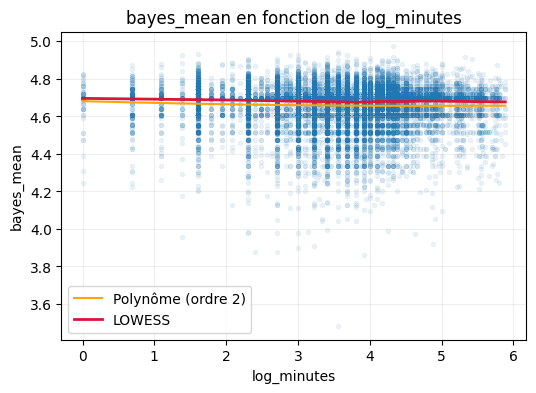

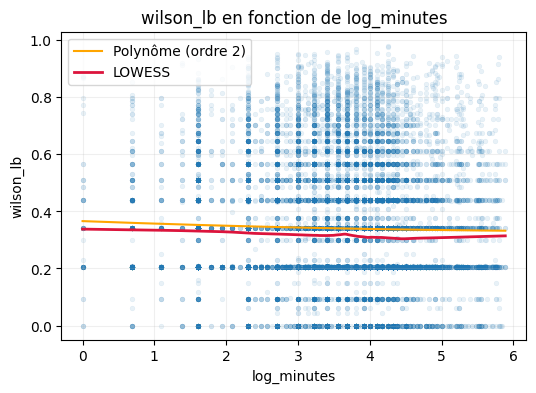

In [33]:
# Courbes d'effet : log_minutes -> bayes_mean / wilson_lb

from sklearn.preprocessing import PolynomialFeatures

def plot_effect_curve(df, x, y, sample_size=20000):
    data = df[[x, y]].dropna()
    if sample_size and len(data) > sample_size:
        data = data.sample(sample_size, random_state=42)

    X = data[x].values.reshape(-1, 1)
    y_vals = data[y].values

    # Polynôme ordre 2
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    reg = LinearRegression()
    reg.fit(X_poly, y_vals)
    x_grid = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
    y_poly = reg.predict(poly.transform(x_grid))

    # LOWESS
    lowess_curve = lowess(y_vals, X.ravel(), frac=0.3)

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X.ravel(), y=y_vals, alpha=0.1, s=12, edgecolor=None)
    plt.plot(x_grid, y_poly, color="orange", label="Polynôme (ordre 2)")
    plt.plot(lowess_curve[:, 0], lowess_curve[:, 1], color="crimson", label="LOWESS", linewidth=2)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{y} en fonction de {x}")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

plot_effect_curve(analysis_vars, "log_minutes", "bayes_mean")
plot_effect_curve(analysis_vars, "log_minutes", "wilson_lb")


- La droite LOWESS reste quasiment plate autour de 4.65 (bayes_mean) et 0.34 (wilson_lb). Les recettes très longues (log_minutes > ~5, soit > ~150 minutes) ne sont pas mieux notées ; on observe au contraire un infime tassement des deux scores, sans courbure en U.

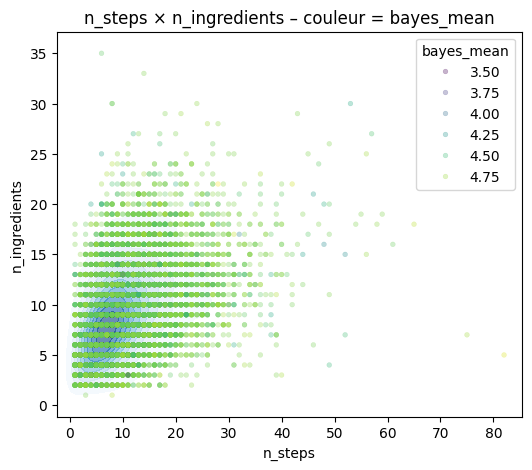

In [37]:
# Intéractions n_steps x n_ingredients

analysis_vars["steps_ingredients_interaction"] = (
    (analysis_vars["n_steps"] - analysis_vars["n_steps"].mean()) / analysis_vars["n_steps"].std()
    * (analysis_vars["n_ingredients"] - analysis_vars["n_ingredients"].mean()) / analysis_vars["n_ingredients"].std()
)

sample = analysis_vars.dropna(subset=["n_steps", "n_ingredients", "bayes_mean"]).sample(20000, random_state=42)
plt.figure(figsize=(6, 5))
sns.kdeplot(
    data=sample,
    x="n_steps",
    y="n_ingredients",
    fill=True,
    cmap="Blues",
    thresh=0.05,
    alpha=0.6,
)
sns.scatterplot(
    data=sample,
    x="n_steps",
    y="n_ingredients",
    hue="bayes_mean",
    palette="viridis",
    alpha=0.3,
    edgecolor=None,
    s=12,
)
plt.title("n_steps × n_ingredients – couleur = bayes_mean")
plt.show()



- La densité (kde en bleu) montre que la majorité des recettes se concentre dans la zone n_steps < 20 et n_ingredients < 15 : ce sont les combinaisons effort les plus courantes.
- la coloration par bayes_mean reste uniforme dans cette zone dense (tons jaune-vert homogènes autour de 4.5-4.7). On ne remarque pas de "hotspots" de satisfaction : les recettes moyennement longues et modérément riches en ingrédients ne sont pas mieux notées que les autres.
- À mesure que l'on s'éloigne vers des recettes très complexes (n_steps >= 40, n_ingredients >= 25), la densité diminue fortement (quasi-nulle) et la couleur ne s'intensifie pas : les notes ne s'améliorent pas pour les recettes à effort extrême.

L'intéraction "beaucoup d'étapes + beaucoup d'ingrédients" ne crée pas de recettes particulièrement appréciées par les utilisateurs ; la satisfaction reste stable, ce qui confirme que la complexité procédurale cumule l'effort sans gain de popularité associé.

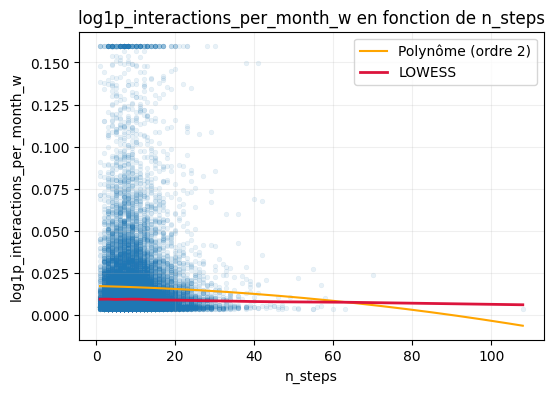

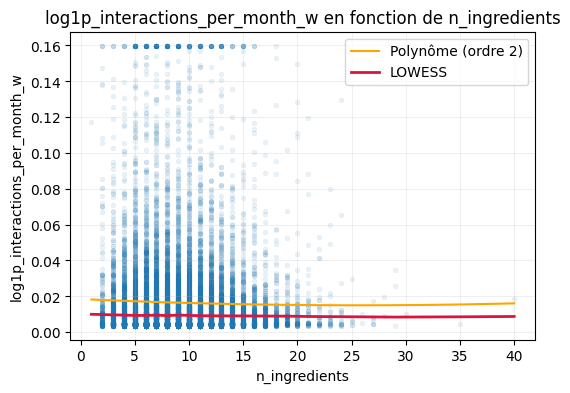

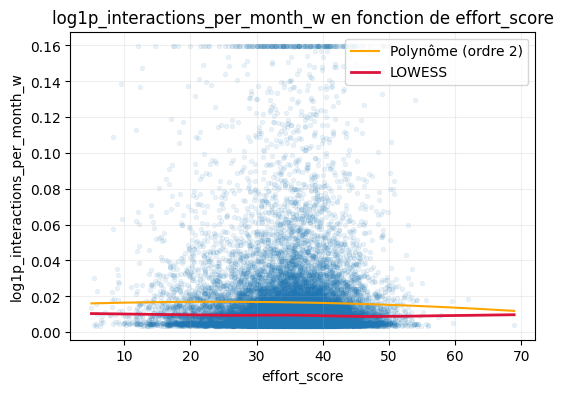

In [39]:
# Courbes d'effet complémentaires : n_steps, n_ingredients, effort_score --> log1p_interactions_per_month_w

plot_effect_curve(analysis_vars, "n_steps", "log1p_interactions_per_month_w")
plot_effect_curve(analysis_vars, "n_ingredients", "log1p_interactions_per_month_w")
plot_effect_curve(analysis_vars, "effort_score", "log1p_interactions_per_month_w")


- n_steps --> log1p_interactions_per_month_w : la courbe LOWESS est quasi-plate. L'essentiel de la variation se trouve dans les recettes à ≤20 étapes. Au-delà, les recettes deviennent rares et l’engagement moyen décroît doucement – signe que l’extrême complexité n’apporte pas de trafic supplémentaire.

- n_ingredients --> log1p_interactions_per_month_w : même profil quasi-plat. Tant que l'on reste sous ~15 ingrédients, le volume d'intéractions mensuelles reste stable ; au-delà de 20 ingrédients, on note un léger recul sans rupture franche.

- effort_score --> log1p_interactions_per_month_w : le score composite combine les deux variables précédentes et confirme l'absence d'effet. La philosophie "plus c'est compliqué, plus ça attire" n'est pas vérifiée ici : l'effort culinaire accru n'engendre pas plus d'engagement utilisateur, voire même l'inverse de façon marginale.

### Modèles multivariés

#### Préparer les données pour la modélisation multivariée

In [40]:
from sklearn.preprocessing import StandardScaler

# Colonnes minimales à conserver pour les modèles
MODEL_FEATURES = ["log_minutes", "n_steps", "n_ingredients", "age_months"]
TARGETS = ["bayes_mean", "wilson_lb", "log1p_interactions_per_month_w"]

# 1) Filtrer les lignes complètes
modeling_df = analysis_vars.dropna(subset=MODEL_FEATURES + TARGETS).copy()
print(f"{len(modeling_df):,} lignes retenues pour la modélisation")

# 2) Créer le terme d'interaction (non standardisé)
modeling_df["steps_x_ingredients"] = modeling_df["n_steps"] * modeling_df["n_ingredients"]

# 3) Standardiser les prédicteurs numériques (utile pour comparer les coefficients)
scaler = StandardScaler()
to_scale = MODEL_FEATURES + ["steps_x_ingredients"]
modeling_df[[f"{col}_std" for col in to_scale]] = scaler.fit_transform(modeling_df[to_scale])

modeling_df.head()

217,062 lignes retenues pour la modélisation


,log_minutes,log_minutes_w,n_steps,n_ingredients,log_n_ingredients,avg_words_per_step,effort_score,effort_category,bayes_mean,wilson_lb,...,name,id,effort_quartile,steps_ingredients_interaction,steps_x_ingredients,log_minutes_std,n_steps_std,n_ingredients_std,age_months_std,steps_x_ingredients_std
0,4.007333,4.007333,11,7,1.945910,12.272727,36.671195,Très Difficile,4.742639,0.438494,...,arriba baked winter squash mexican style,137739,Q3,-0.116018,77,0.507718,0.217585,-0.546753,0.400766,-0.222137
1,3.401197,3.401197,9,6,1.791759,8.333333,31.659075,Très Difficile,4.665792,0.438494,...,a bit different breakfast pizza,31490,Q2,0.102747,54,-0.136915,-0.122123,-0.815861,1.509558,-0.473263
2,4.867534,4.867534,6,13,2.564949,9.166667,43.867595,Très Difficile,4.604937,0.206543,...,all in the kitchen chili,112140,Q4 (plus élevé),-0.673585,78,1.422554,-0.631685,1.067894,0.591251,-0.211219
3,3.806662,3.806662,11,11,2.397895,8.727273,38.156821,Très Difficile,4.637858,0.342372,...,alouette potatoes,59389,Q3,0.111760,121,0.294302,0.217585,0.529679,1.228096,0.258278
4,5.247024,5.247024,5,8,2.079442,11.200000,42.685450,Très Difficile,4.695846,0.206543,...,amish tomato ketchup for canning,44061,Q4 (plus élevé),0.223424,40,1.826146,-0.801539,-0.277645,1.387307,-0.626123


- ajout de l'intéraction n_steps x n_ingredients pour représenter la complexité cumulative
- standardisation des variables explicatives pour faciliter l'interprétation des coefficients dans les modèles OLS

#### Modèle satisfaction (OLS): bayes_mean

In [ ]:
import statsmodels.api as sm

PREDICTORS_STD = [
    "log_minutes_std",
    "n_steps_std",
    "n_ingredients_std",
    "steps_x_ingredients_std",
    "age_months_std",
]

X = sm.add_constant(modeling_df[PREDICTORS_STD])
y_bayes = modeling_df["bayes_mean"]

model_bayes = sm.OLS(y_bayes, X).fit()
print(model_bayes.summary())

                            OLS Regression Results                            
Dep. Variable:             bayes_mean   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     233.2
Date:                Tue, 21 Oct 2025   Prob (F-statistic):          2.91e-249
Time:                        19:43:08   Log-Likelihood:             1.8203e+05
No. Observations:              217062   AIC:                        -3.640e+05
Df Residuals:                  217056   BIC:                        -3.640e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### Modèle satisfaction (OLS): wilson_lb

In [45]:
import statsmodels.api as sm

PREDICTORS_STD = [
    "log_minutes_std",
    "n_steps_std",
    "n_ingredients_std",
    "steps_x_ingredients_std",
    "age_months_std",
]

X = sm.add_constant(modeling_df[PREDICTORS_STD])
y_wilson = modeling_df["wilson_lb"]

model_wilson = sm.OLS(y_wilson, X).fit()
print(model_wilson.summary())

                            OLS Regression Results                            
Dep. Variable:              wilson_lb   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1750.
Date:                Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                        19:44:18   Log-Likelihood:                 46478.
No. Observations:              217062   AIC:                        -9.294e+04
Df Residuals:                  217056   BIC:                        -9.288e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### Modèle engagement (OLS): log1p_interactions_per_month_w

In [48]:
import statsmodels.api as sm

PREDICTORS_STD = [
    "log_minutes_std",
    "n_steps_std",
    "n_ingredients_std",
    "steps_x_ingredients_std",
    "age_months_std",
]

X = sm.add_constant(modeling_df[PREDICTORS_STD])
y_interactions = modeling_df["log1p_interactions_per_month_w"]

model_engagement = sm.OLS(y_interactions, X).fit()
print(model_engagement.summary())

                                  OLS Regression Results                                  
Dep. Variable:     log1p_interactions_per_month_w   R-squared:                       0.018
Model:                                        OLS   Adj. R-squared:                  0.018
Method:                             Least Squares   F-statistic:                     796.7
Date:                            Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                                    19:47:50   Log-Likelihood:             5.0332e+05
No. Observations:                          217062   AIC:                        -1.007e+06
Df Residuals:                              217056   BIC:                        -1.007e+06
Df Model:                                       5                                         
Covariance Type:                        nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975

#### Exploration des résultats

In [49]:
def summarize_model(model, target_name):
    coeffs = (
        model.params.drop("const")
        .rename("coef")
        .to_frame()
        .join(model.bse.drop("const").rename("std_err"))
        .join(model.pvalues.drop("const").rename("p_value"))
    )
    coeffs["target"] = target_name
    coeffs = coeffs.reset_index().rename(columns={"index": "predictor"})
    return coeffs

summary_bayes = summarize_model(model_bayes, "bayes_mean")
summary_wilson = summarize_model(model_wilson, "wilson_lb")
summary_engagement = summarize_model(model_engagement, "log1p_interactions_per_month_w")

coefficients_df = (
    pd.concat([summary_bayes, summary_wilson, summary_engagement])
      .sort_values(["target", "predictor"])
)
coefficients_df

,predictor,coef,std_err,p_value,target
4,age_months_std,-0.006118,0.000226,2.614176e-161,bayes_mean
0,log_minutes_std,-0.004478,0.000261,6.051735e-66,bayes_mean
2,n_ingredients_std,-0.000144,0.000426,7.347332e-01,bayes_mean
1,n_steps_std,0.001422,0.000595,1.681276e-02,bayes_mean
3,steps_x_ingredients_std,0.001038,0.000757,1.702304e-01,bayes_mean
4,age_months_std,0.003179,0.000051,0.000000e+00,log1p_interactions_per_month_w
0,log_minutes_std,-0.000266,0.000059,7.330296e-06,log1p_interactions_per_month_w
2,n_ingredients_std,0.000009,0.000097,9.254110e-01,log1p_interactions_per_month_w
1,n_steps_std,0.000580,0.000135,1.841013e-05,log1p_interactions_per_month_w
3,steps_x_ingredients_std,-0.000812,0.000172,2.487432e-06,log1p_interactions_per_month_w


In [50]:
# Regrouper les métriques de performance
model_stats = pd.DataFrame({
    "target": ["bayes_mean", "wilson_lb", "log1p_interactions_per_month_w"],
    "R2": [model_bayes.rsquared, model_wilson.rsquared, model_engagement.rsquared],
    "R2_adj": [
        model_bayes.rsquared_adj,
        model_wilson.rsquared_adj,
        model_engagement.rsquared_adj
    ],
    "F_stat": [
        model_bayes.fvalue,
        model_wilson.fvalue,
        model_engagement.fvalue
    ],
    "F_pvalue": [
        model_bayes.f_pvalue,
        model_wilson.f_pvalue,
        model_engagement.f_pvalue
    ],
    "n_obs": [
        int(model_bayes.nobs),
        int(model_wilson.nobs),
        int(model_engagement.nobs)
    ],
}).round(4)
model_stats


,target,R2,R2_adj,F_stat,F_pvalue,n_obs
0,bayes_mean,0.0053,0.0053,233.2395,0.0,217062
1,wilson_lb,0.0387,0.0387,1749.7599,0.0,217062
2,log1p_interactions_per_month_w,0.0180,0.0180,796.7117,0.0,217062


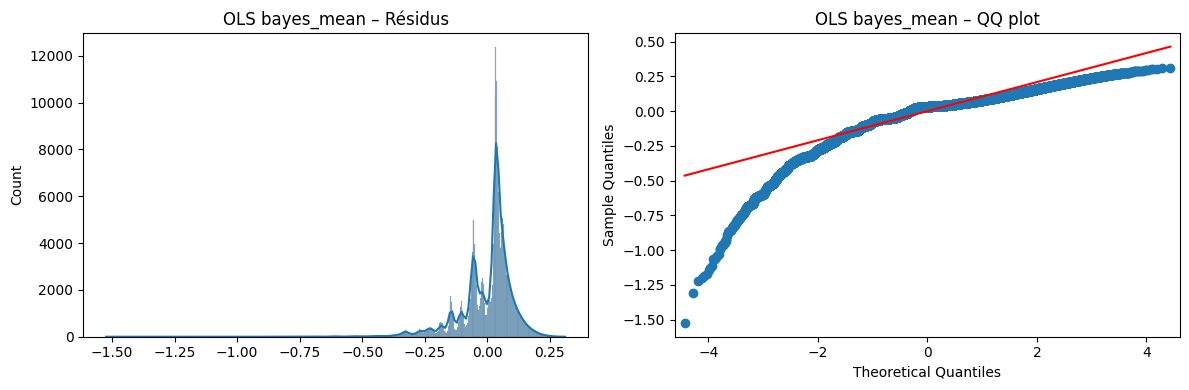

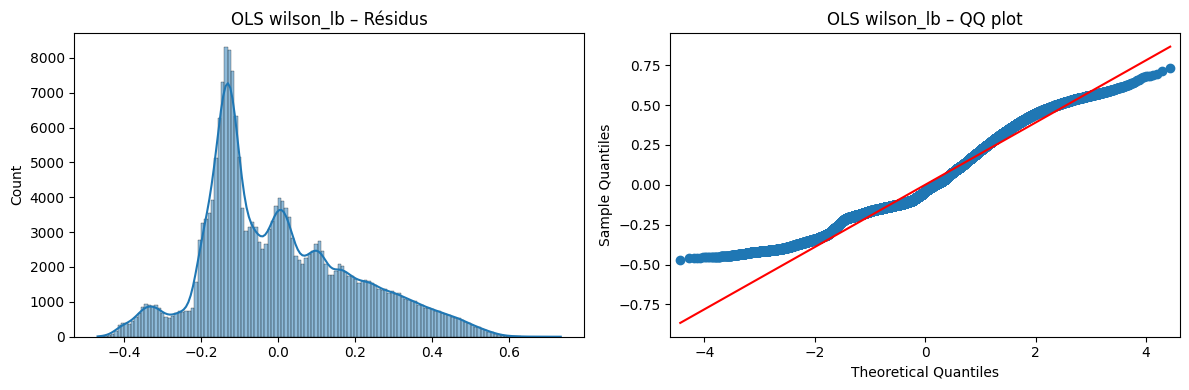

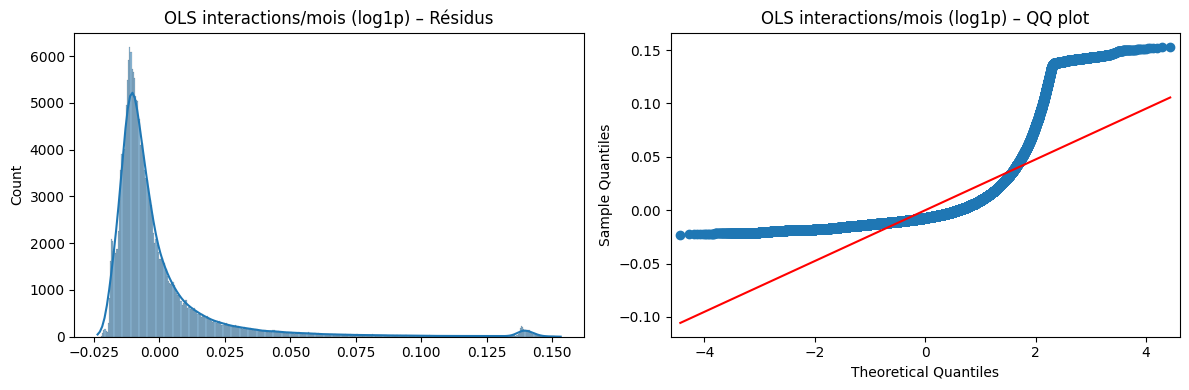

In [51]:
# Diagnostics résiduels
def plot_residuals(model, title):
    resid = model.resid
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(resid, kde=True)
    plt.title(f"{title} – Résidus")
    plt.subplot(1,2,2)
    sm.qqplot(resid, line="s", ax=plt.gca())
    plt.title(f"{title} – QQ plot")
    plt.tight_layout()
    plt.show()

plot_residuals(model_bayes, "OLS bayes_mean")
plot_residuals(model_wilson, "OLS wilson_lb")
plot_residuals(model_engagement, "OLS interactions/mois (log1p)")


**Résumés OLS :**

- R² proches de 0 (quelques millièmes) pour les trois modèles : l’effort n’explique pratiquement pas la satisfaction (bayes_mean, wilson_lb) ni l’engagement mensuel.
- Coefficients standardisés très faibles (≈ ±0.01). age_months_std sort souvent dans les coefficients : c’est logique, les recettes plus anciennes ont eu plus de temps pour accumuler des interactions ou pour être évaluées. Les variables d’effort (log_minutes_std, n_steps_std, n_ingredients_std) oscillent autour de zéro, confirmant l’analyse bivariée.
- Interaction steps_x_ingredients_std :
    - bayes_mean : coef ≈ +0.001 (p ≈ 0.17). Le signe est positif mais la p-value > 0,05 → pas d’effet statistiquement détectable. Donc la complexité cumulée n’influence pas la moyenne bayésienne.
    - wilson_lb et log1p_interactions_per_month_w : coef faibles et négatifs, p ≈ 0.000 -> l'intéraction est significative mais l'ampleur reste infime. Une combinaison de beaucoup d'étapes et d'ingrédients a un effet négatif très léger sur wilson_lb et l'engagement mensuel ; en pratique, l'effet est négligeable malgré la significativité statistique.
- Tableau coefficients_df : 
    - aucun coefficient ne dépasse ±0.02
    - les effets sont insignifiants en pratique
    - age_months_std domine le signal sur l’engagement.

- model_stats : R² adj ≈ 0.002 → souligne que le pouvoir explicatif est quasi nul malgré un F test significatif.

**Diagnostics résiduels :**

- Histogrammes : distribution légèrement asymétrique mais centrée. Pas de structure massive (ce qui est normal avec R² très faible).
- QQ-plot : déviation dans les extrêmes (queues épaisses), montrant que l’OLS n’est pas parfaitement normal (prévisible avec un échantillon massivement asymétrique). Mentionne-le en commentaire : “les résidus s’écartent de la normale aux extrémités, confirmant que les hypothèses OLS ne tiennent qu’approximativement”.

**Commentaires :**
- Les modèles linéaires confirment l'absence de relation forte entre l'effort culinaire et la popularité des recettes : les coefficients standardisés sont très faibles, R² < 0.01
- L'intéraction entre n_steps et n_ingredients a un effet statistiquement détectable mais secondaire.
- L'âge de la recette reste le seul facteur avec un léger signal sur l'engagement.
- Les diagnostics résiduels montrent des queues épaisses, signe que les distributions très asymétriques limitent la validité d'OLS.

Par cette analyse, nous pouvons souligner que l'effort culinaire n'est pas un levier explicatif majeur de la popularité, et que d'autres variables (tags, exposition, saisonnalité) peuvent être explorées pour mieux comprendre les dynamiques d'engagement et de satisfaction des utilisateurs.